# Introduction
This notebook gives an example how we do EDA (explorative data analysis).  
It is the first one in a series of 3 notebooks. The other two notebooks load the results of this notebook and implement model comparison and model interpretation respectively.  
For a better understanding you should have basic knowledge of predictive modelling, i.e. know what a logistic regression is or cross-validation, for instance.  
As example data source the well known titanic data set is chosen (TODO: link). It is therefore a classification problem (with binary target *survived/not survived*).  
Even though you cannot compare the titanic case with a real life setting, the following steps pretty much reflect (on a small scale!) how we conduct data analysis in predictive modeling projects. Therefore is different from the many tutorials you find in the web using the same data.

# 0. Packages and settings

We start by loading packages and do some basic settings (data and output locations, parameters, ...). Furthermore the *0_init.R* program defines many functions, mainly for plotting, which are frequently used in this notebook. The detailed implementation of these functions is not important for understanding the EDA approach presented here.


In [11]:
#getwd()
setwd("C:/My/Projekte/PredMod_Template/") 
source("./code/0_init.R")

In [12]:
#DELTE THIS:
# Adapt some default parameter different for target types -> probably also different for a new use-case
#color = switch(TYPE, "CLASS" = twocol, "REGR" = hexcol, "MULTICLASS" = threecol) #probably need to change MULTICLASS opt
#cutoff = switch(TYPE, "CLASS" = 0.1, "REGR"  = 0.9, "MULTICLASS" = 0.9) #need to adapt
#ylim = switch(TYPE, "CLASS" = NULL, "REGR"  = c(0,2.5e5), "MULTICLASS" = NULL) #need to adapt in regression case
#min_width = switch(TYPE, "CLASS" = 0, "REGR"  = 0, "MULTICLASS" = 0.2) #need to adapt in multiclass case


# 1. ETL
We need to do some ETL (extract, transform, load) 
## 1.1 Read data and conduct quick check

In [13]:
df.orig = read_csv(paste0(dataloc,"titanic.csv"), col_names = TRUE) #read data

Parsed with column specification:
cols(
  pclass = col_character(),
  survived = col_integer(),
  name = col_character(),
  sex = col_character(),
  age = col_double(),
  sibsp = col_integer(),
  parch = col_integer(),
  ticket = col_character(),
  fare = col_double(),
  cabin = col_character(),
  embarked = col_character(),
  boat = col_character(),
  body = col_integer(),
  home.dest = col_character()
)


Let's do a quick check of the data:

In [44]:
df.orig %>% mutate_if(is.character, as.factor) %>% summary(.)

 pclass       survived                                  name          sex     
 1st:323   Min.   :0.000   Connolly, Miss. Kate           :   2   female:466  
 2nd:277   1st Qu.:0.000   Kelly, Mr. James               :   2   male  :843  
 3rd:709   Median :0.000   Abbing, Mr. Anthony            :   1               
           Mean   :0.382   Abbott, Master. Eugene Joseph  :   1               
           3rd Qu.:1.000   Abbott, Mr. Rossmore Edward    :   1               
           Max.   :1.000   Abbott, Mrs. Stanton (Rosa Hunt:   1               
                           (Other)                        :1301               
      age              sibsp            parch            ticket    
 Min.   : 0.1667   Min.   :0.0000   Min.   :0.000   CA. 2343:  11  
 1st Qu.:21.0000   1st Qu.:0.0000   1st Qu.:0.000   1601    :   8  
 Median :28.0000   Median :0.0000   Median :0.000   CA 2144 :   8  
 Mean   :29.8811   Mean   :0.4989   Mean   :0.385   3101295 :   7  
 3rd Qu.:39.0000   3rd Qu.:1

+ We see that 38.2% of all passengers survived.
+ Some columns have missings
+ *name* and *ticket* do seem to be useless for analysis as this information is to detailed
+ *cabin* seems to be a list of all cabins associated with a ticket (valid for several persons)  

In real data situations much more of these findings and data issues will pop up and need to be precisely reviewed usually together with business and data people!  
**It is absolut important to fully understand the input data for a prediction problem!**

Before transforming the data we create a copy of the original data. In case of bigger datasets which take much longer to be read this helps for faster implementation in case some errornous tansformation will be done. Actually for the titanic data this is not really needed.

In [14]:
df = df.orig #"save" original data

## 1.2 Define target and train/test fold  
After defining the target we already specify the train/test fold. Here we use a random 70/30 split, but just because we do not have a time related variable.  
It is absolutely important to do the split time based in real life situations! First of all you usually want to predict something in the future (e.g. "will a customer churn"), so you best simulate this by a time based split. And as variable distributions as well as relations to the target can change over time, a pure random split usually would result in an overly positive predictive performance which you would not see in your first back testing in production. Last but not least, using time based features like calendar-week, day-of-month, etc. might result in some overfitting which you only cannot identify by a random split.

In [15]:
# Target
df = mutate(df, target = factor(ifelse(survived == 0, "N", "Y"), levels = c("N","Y")), #factor needed by caret package
                target_num = ifelse(target == "N", 0 ,1)) 

# Train/Test fold
df$fold = factor("train", levels = c("train", "test"))
set.seed(123)
df[sample(1:nrow(df), floor(0.3*nrow(df))),"fold"] = "test" #random 70/30 split
summary(df[c("target","target_num","fold")])

 target    target_num       fold    
 N:809   Min.   :0.000   train:917  
 Y:500   1st Qu.:0.000   test :392  
         Median :0.000              
         Mean   :0.382              
         3rd Qu.:1.000              
         Max.   :1.000              

## 1.1 Feature engineering
Now one of the most important steps in predictive modeling has to be done: Feature engineering, i.e. deriving new information.  
Even the most ambtious machine learning algorithms profit from feature engineering as it helps the algorithm to "find the signal". In case of infinite data an algorithm like deep neural nets is capable of finding all realations the features have with the target. But you will never have inifite data ... even in times of *big data*.  
For the titanic data there is not much to do here, but in real life situations it is not unusual that you create as many new features as original input data columns. In such cases it often happens that most of the feature engineering is done on database side where the data originates.

In [16]:
df$deck = as.factor(str_sub(df$cabin, 1, 1))#deck as first character of cabin
df$familysize = df$sibsp + df$parch + 1 #add number of siblings and spouses to number of parents and children
# TODO fare per person
summary(df[c("deck","familysize")]) 


      deck        familysize    
 C      :  94   Min.   : 1.000  
 B      :  65   1st Qu.: 1.000  
 D      :  46   Median : 1.000  
 E      :  41   Mean   : 1.884  
 A      :  22   3rd Qu.: 2.000  
 (Other):  27   Max.   :11.000  
 NA's   :1014                   

# 2 Metric features: Explore and adapt

We first define the names of the metric covariates in a simple character vector.  
In real life you will have much more metric features (and nominal as well), which might be created in parallel to your data analysis implementation (see *feature engineering* above). Then it makes much more sense to administer the definition of the features togther with some metadata (implementation status, e.g. "under construction", typical values, comments regarding derivation, etc.) in an external tool. For a pragmatic approach an execel sheet nicely fits the requirement and can be automaticaly read by your program. In such cases you should directly check the consistency of this *datamodel.xls* with the current data you load. 

In [17]:
# Define metric covariates
metr = c("age","fare")
summary(df[metr]) 

      age               fare        
 Min.   : 0.1667   Min.   :  0.000  
 1st Qu.:21.0000   1st Qu.:  7.896  
 Median :28.0000   Median : 14.454  
 Mean   :29.8811   Mean   : 33.295  
 3rd Qu.:39.0000   3rd Qu.: 31.275  
 Max.   :80.0000   Max.   :512.329  
 NA's   :263       NA's   :1        

## 2.1 Binning

We now create a "binned" copy of every metric feature, i.e. we group the values into bins determined by 10 quantiles of the metric feature.  
This binned copy is used below for some plots. 
But more importantly, we later use these newly created nominal variables as features instead of the original variables for an elastic-net algorithm.  
<br>
Even though the binning throws away some information it has several advantages in conjunction with a "linear model" like the elastic-net:  
+ Ability to approximate nonlinear effects with a linear model (as each bin can get its own effect)
+ Elegant handling of missing values as these are grouped into a seperate member named "(Missing)"
+ No worries about outliers in feature space as these are nicely grouped with non-outliers in the edge bins
+ Also skewness (see below) is not an issue any more due to the quantile based binning

In [18]:
# Create nominal variables for all metric variables  -------------------------------

metr_binned = paste0(metr,"_BINNED_")
df[metr_binned] = map(df[metr], ~ {
  # Hint: Adapt sequence increment in case you have lots of data 
  cut(., unique(quantile(., seq(0, 1, 0.1), na.rm = TRUE)), include.lowest = TRUE)  
})

# Convert missings to own level "(Missing)"
df[metr_binned] = map(df[metr_binned], ~ fct_explicit_na(., na_level = "(Missing)"))
summary(df[metr_binned],11)

     age_BINNED_       fare_BINNED_
 [0.167,14]:107   [0,7.57]   :131  
 (14,19]   :118   (7.57,7.85]:144  
 (19,22]   :108   (7.85,8.05]:146  
 (22,25]   :110   (8.05,10.5]:108  
 (25,28]   : 93   (10.5,14.5]:128  
 (28,31]   : 98   (14.5,21.7]:130  
 (31,36]   :121   (21.7,27]  :128  
 (36,42]   : 96   (27,41.6]  :134  
 (42,50]   :100   (41.6,78.1]:128  
 (50,80]   : 95   (78.1,512] :131  
 (Missing) :263   (Missing)  :  1  

## 2.2 Handling of missings, outliers, skewness
When we want to use the original metric variables with other algorithms like "standard" GLM (generalized linear models, including logistic regression), SVM (support vector machines) or deep neural nets, we now need to care about missings, outliers and skewness occuring for the features. 

All the following coding steps help non-tree-based algorithms to find the signal. Why do we state "non-tree-based" here? Actually all algorithms based on decision trees, like random forest or boosted decision trees (e.g. xgboost), do not suffer from these issues: Missings are treated as a special value which can be used in all splits, feature outliers almost do not influence tree splits, feature skewness need not be handled by a montone transformation as trees are invariant to such adaptions.

First of all we remove features with too many missings. But how much is too many? In classic statistical analysis you 
still see that features (or *covariates*) are removed if they contain 50% missings. Actually in data science utilizing machine
learning algorithms, this threshold is much higher. It is not unusual to keep variables with 99% missings. This threshold is also used in the following and can be seen as a rule of thumb (and is therefore rough and not applicable in all cases).  
For titanic the metric features are far away from this threshold.  
Later we will care about the missings more detailed, i.e. remove them by imputation. But for now we keep them as is for some additional analysis.

In [19]:
# Remove covariates with too many missings from metr 
misspct = map_dbl(df[metr], ~ round(sum(is.na(.)/nrow(df)), 3)) #misssing percentage
print(misspct[order(misspct, decreasing = TRUE)]) #view in descending order
(remove = names(misspct[misspct > 0.99])) #vars to remove
metr = setdiff(metr, remove) #adapt metadata
metr_binned = setdiff(metr_binned, paste0(remove,"_BINNED_")) #keep "binned" version in sync

  age  fare 
0.201 0.001 


character(0)

We already create some initial plot to check whether there are outliers or skewed distributions. The distributions are stratified by the target. The reason behind this kind of display is explained later.

      age               fare        
 Min.   : 0.1667   Min.   :  0.000  
 1st Qu.:21.0000   1st Qu.:  7.896  
 Median :28.0000   Median : 14.454  
 Mean   :29.8811   Mean   : 33.295  
 3rd Qu.:39.0000   3rd Qu.: 31.275  
 Max.   :80.0000   Max.   :512.329  
 NA's   :263       NA's   :1        

[1] "age"
[1] "fare"


[[1]]
NULL


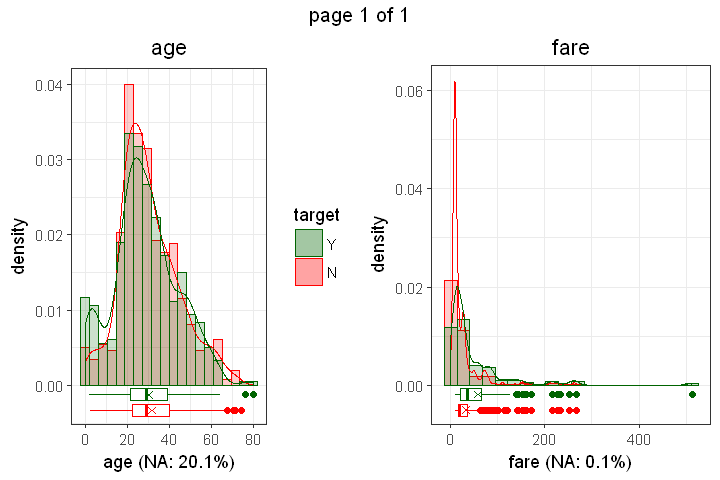

In [20]:
# Check for outliers and skewness
summary(df[metr]) 
options(warn = -1) #suppress unwanted messages
plots = suppressMessages(get_plot_distr_metr(df, metr, color = twocol, missinfo = misspct, ylim = c(0,1))) #distribution plot
options(repr.plot.width = 6, repr.plot.height = 4) #adapt this for different resolution
marrangeGrob(suppressMessages(plots), ncol = 2, nrow = 1) #arrange plots
options(warn = 0) #reset warnings

For "age" we do not see anything unusual. 
But for "fare" we can clearly identify at least one clear outlier above 500. Furthermore the distribution is highly right-skewed.  
An easy approach to handle outliers is to winsorize the data, i.e. set all values below the .01 quantile to the quantile value and do the same for data above the .99 quantile. Sometimes this already fixes some skewness in extreme cases.  


In [21]:
# Winsorize
df[metr] = map(df[metr], ~ winsorize(., 0.01, 0.99)) #hint: one might want to plot again before deciding for log-trafo

Skewness: The most common case are right-skewed variables as you often face features that are unrestricted to the right but restricted to the left by zero. This kind of skewness can often be fixed a log-transformation. A more flexible alternative is the so-called Box-Cox trafo for which the log trafo is a special case. The Box-Cox seeks for normality which is useful but not absoutely needed.

In [22]:
# Log-Transform
tolog = c("fare") #variable to transform
df[paste0(tolog,"_LOG_")] = map(df[tolog], ~ {if(min(., na.rm=TRUE) == 0) log(.+1) else log(.)}) #log(x) or log(x+1) trafo
metr = map_chr(metr, ~ ifelse(. %in% tolog, paste0(.,"_LOG_"), .)) #adapt metadata (and keep order)
names(misspct) = map_chr(names(misspct), ~ ifelse(. %in% tolog, paste0(.,"_LOG_"), .)) #keep misspct in sync
summary(df[paste0(tolog,"_LOG_")])

   fare_LOG_    
 Min.   :0.000  
 1st Qu.:2.186  
 Median :2.738  
 Mean   :2.977  
 3rd Qu.:3.474  
 Max.   :5.574  
 NA's   :1      

We are now ready to get the final distribution plot for the metric features. This plot has several characteristics helping to judge the features:  
+ We also print the univariate variable importance, which, for a classification problem, is identical with the in-sample (or "training") AUC (area under the curve) you can achieve if you solely use one feature to predict the target 
+ Before calculating it we impute the missing values with random non-missing values from the same variable which assures that the univariate variable importance is not overly optimistic due to a restriction to the non-missing variable values. 
+ But we add the percentage of missings to better justify the importance of the feature 
+ The stratification by the target helps to identify the effect on the target
+ The boxplots below the distribution plots supports in showing outliers and in comparison of the mean (marked by the cross) and the median (marked by the bar) of the feature in the two target strata
+ We additionally plot the effect of the binned versions of the features which sometimes is advantageous in visualizing the effect on the target (with the dotted line showing the base ratio of the target, i.e. 38% survival rate). Do not get confused by the unequal percentage of observations for each bin which is printed in brackets behind the bin edges; this can occur in case of too few distinct values of the original variable 
+ The binned version plot also helps in identifying informative missings by comparing the effect of the "(Missing)" bin with the others.


Especially the last bullet is important. If you already see here an effect which is "too good to be true", you might have created some form of *data leakage*. This isssue always occurs if you have some data relations in your training data that would not occur in a similar way for your future test data and therefore would result in a much lesser predictive performance for the latter. The data leakage can have several reasons: you might have incorporated "self-predictors" or "information from the future" as explained for the nominal features below. In such a case you need to fix the leakage, e.g. by removing the self-predictors from your feature vector.

fare_LOG_       age 
     0.67      0.52

[1] "age"
[1] "fare_LOG_"
[1] "age_BINNED_"
[1] "fare_BINNED_"


[[1]]
NULL


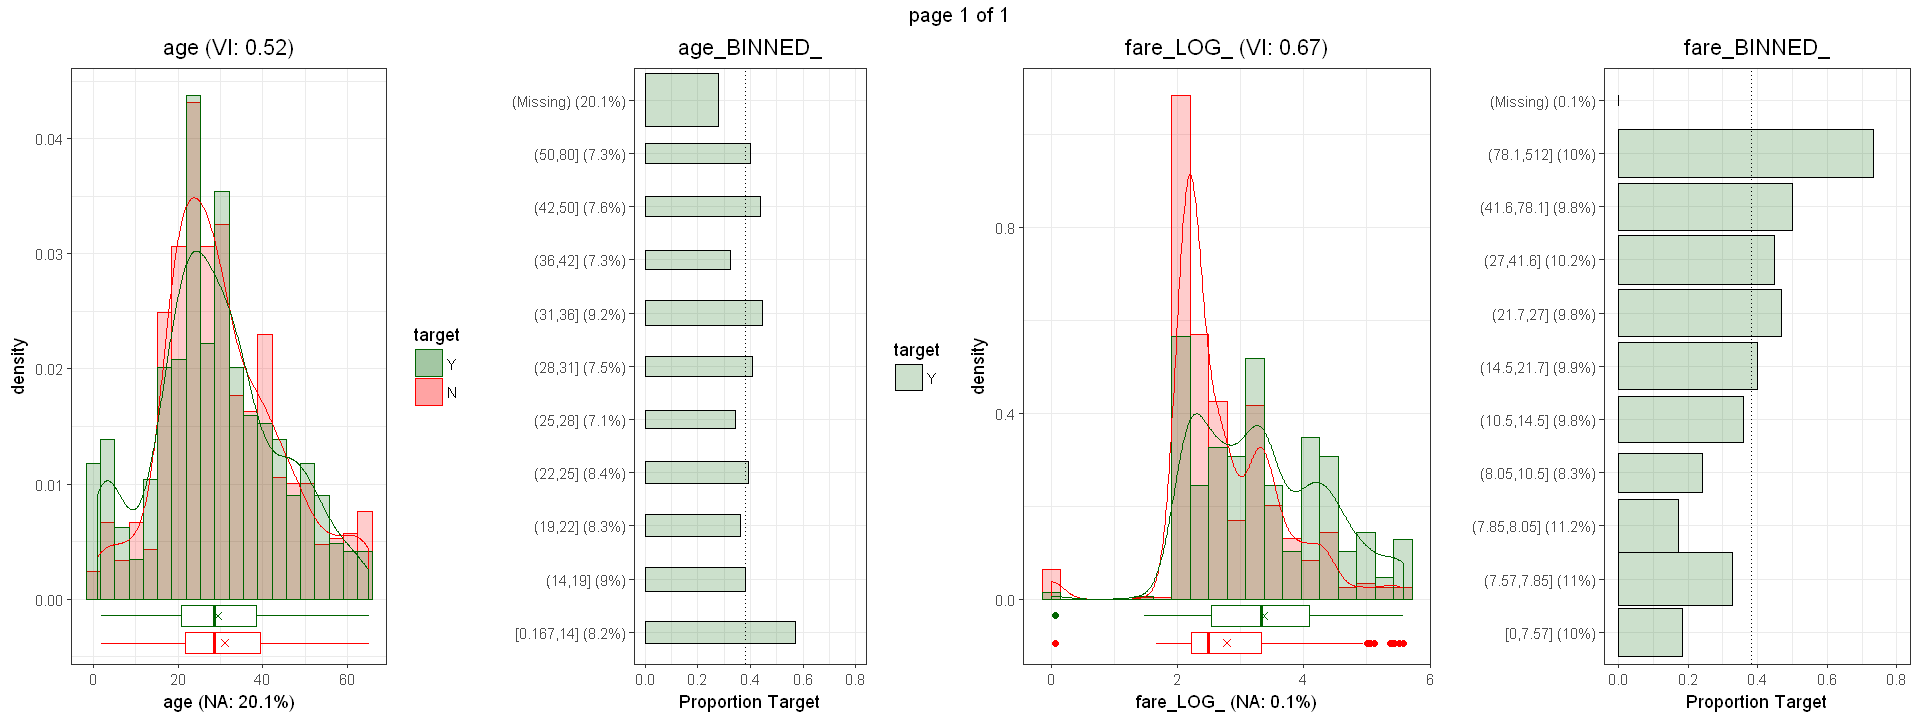

In [23]:
# Univariate variable importance: with random imputation!
(varimp_metr = (filterVarImp(map_df(df[metr], ~ impute(.)), df$target, nonpara = TRUE) %>% rowMeans() %>% 
                  .[order(., decreasing = TRUE)] %>% round(2)))

# Plot 
options(warn = -1) #suppress unwanted messages
plots1 = suppressMessages(get_plot_distr_metr(df, metr, color = twocol, 
                                             missinfo = misspct, varimpinfo = varimp_metr, ylim = NULL)) #distribution plot
plots2 = suppressMessages(get_plot_distr_nomi(df, metr_binned, color = twocol, varimpinfo = NULL, inner_barplot = FALSE,
                                              min_width = 0.2, ylim = c(0,0.8))) #binned variable plot
plots = list() ; for (i in 1:length(plots1)) {plots = c(plots, plots1[i], plots2[i])} #zip plots
#options(jupyter.plot_mimetypes = "image/svg+xml")
options(jupyter.plot_mimetypes = "image/png")
options(repr.plot.width = 16, repr.plot.height = 6) #adapt this for different resolution
marrangeGrob(suppressMessages(plots), ncol = 4, nrow = 1) #arrange plots
options(warn = 0) #reset warnings



We see that children have a higher probability to survive. Apart from that only the lower survial rate in case of a missing **age** (see the binned age plot) pops up regarding passenger age. Even though this effect is not huge it hints to a possible data leakage, i.e. that age was recorded after the accident which a higher probability of response due to survival of the passenger. This example for "information from the future" nicely corresponds to typical business data situations where special data flags are set after the event of interest and are therefore useless for predicting the future. We emphasize this issue again as it is one of the biggest problems in real life predictive models! Actually for the titanic data an alternative explanation can be that 3rd class passengers that have a lower survival rate (see the forthcoming analysis) have not reported their age.  
Furthermore we can identify that **fare** is highly predictable for the target (AUC: 0.67) which is due to a nearly linear trend. Keep in mind that this is still a univariate influence and might change if we adjust for the other features in the final multivarite model. E.g. the effect might be *confounded* by the passenger class which might be the causal reason behind this effect as first class passengers (which pay a higher fare) are nearer to the deck and due to this reason had a higher chance to survive.  
Additionally we nicely see how the log trafo also rectifies the low fares showing now a gap between the zero dollar fares and the rest.  
  
  
By this discussion of just the two plots you get an impression what has to be checked in real life situations with dozens of metric variables. 

In [24]:
# Remove self-predictors
metr = setdiff(metr, "xxx")

## 2.2 Correlation analysis

Now we investigate the relation between the metric features by a correlation analysis. When using classical regression approaches (without any regularization by penalization) this is would be a very important step as highly correlated covariates would lead to the so-called multicollinearity problem. As a consequence the estimates of the model parameters (i.e. the beta coefficients in the model equation) would be highly instable and the predicctive performance of the model would decrease drastically. In times of robust machine learning algorithms that can handle this issue, we use the correlation analysis mostly to identify "duplicates" of variables, which can be removed without any loss. It is not unusual that under a high amount of metric features you find several which measure the same thing, e.g. revenue-per-month and revenue-per-year, which would pop up in a correlation matrix plot. In such a case we remove the variable which has more missings. Therefore we directly plot the missing rate for each variable beside the variable name. Futhermore we only plot the correlations above a cutoff value in order to keep the plot manageable. Often we choose .97, but then only look at correlations abovve .99 for the "duplicate" candidates. For the small titanic data none of above advices are relevant.

We almost always plot the Spearman correlation, which is based on the ranks of the variable values and more robust against outliers than the better known Pearson correlation. Since we took care about outliers by previous steps this might not be needed, but furthermore the Spearman correlation can also better identify non-linear (but monotone) correlations. And we take the absolute value as for our purpose it does not make a difference if the correlation is negative or positive.

At least this analysis also helps to understand the data in hand.

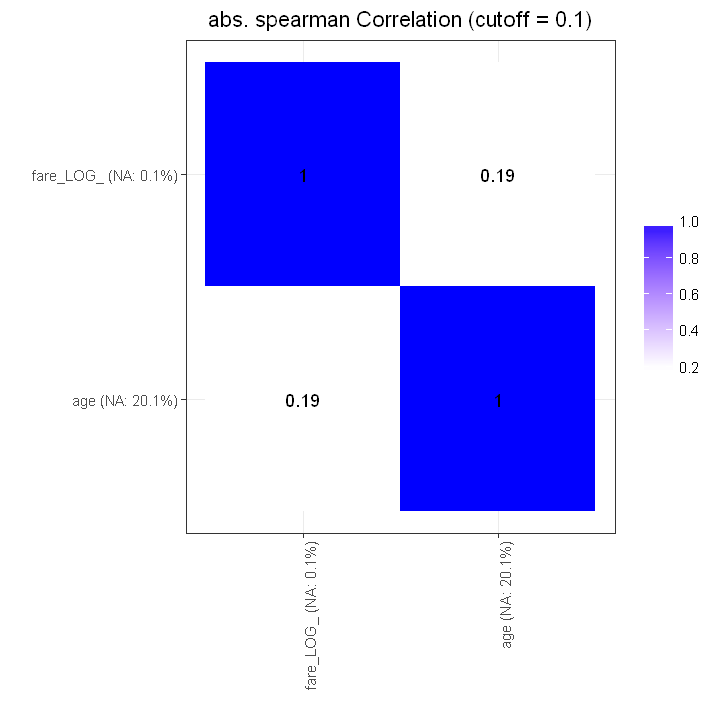

In [26]:
# Plot absolute spearman correlation for metric features
plot = get_plot_corr(df, input_type = "metr", vars = metr, 
                     missinfo = misspct, cutoff = 0.1) #plot all variables with at least one correlation above 0.1
options(repr.plot.width = 6, repr.plot.height = 6) #adapt this for different resolution
plot

In [27]:
# Remove highly/perfectly (>=99%) correlated variables (i.e. the ones with less NA!)
remove = c("xxx") #put at xxx the variables to remove
metr = setdiff(metr, c("xxx")) #remove
metr_binned = setdiff(metr_binned, paste0(c("xxx"),"_BINNED_")) #keep "binned" version in sync

## 2.3 Time or train/test-fold dependency

In [24]:
'''
# Time/fold depedency --------------------------------------------------------------------------------------------

# Hint: In case of having a detailed date variable this can be used as regression target here as well!

# Univariate variable importance (again ONLY for non-missing observations!)
df$fold_test = factor(ifelse(df$fold == "test", "Y", "N"))
(varimp_metr_fold = filterVarImp(df[metr], df$fold_test, nonpara = TRUE) %>% rowMeans() %>%
    .[order(., decreasing = TRUE)] %>% round(2))

# Plot: only variables with with highest importance
metr_toprint = names(varimp_metr_fold)[varimp_metr_fold >= 0.52]
options(warn = -1)
plots = get_plot_distr_metr(df, metr_toprint, color = c("blue","red"), target_name = "fold_test", 
                            missinfo = misspct, varimpinfo = varimp_metr_fold, ylim = ylim)
ggsave(paste0(plotloc, TYPE, "_distr_metr_final_folddependency.pdf"), marrangeGrob(plots, ncol = 4, nrow = 2), 
       width = 18, height = 12)
options(warn = 0)


ERROR: Error in parse(text = x, srcfile = src): <text>:1:3: unexpected INCOMPLETE_STRING
18: options(warn = 0)
19: 
      ^


## 2.4 Missings "again", now impute

After we finished all processing of the metric variables we can now impute missing values. But before, we derive for each feature comprising any missing values, a sepearte missing value indicator (i.e. a nominal flag) which we add to the feature vector (see next section). THis is due to the chance that the missings can be informative wich means that they have predictive capability with regard to the target.  
We choose a random imputation here becauese we are still in the explorative modus and do not want the missing indicator effect get mixed with an effect resulting from the median of a feature, wich would happen when we would use the typical median imputation. Be aware that for any scoring data you prepare, you never should use random imputation as this created the chance of nonsense predictions due to imputation of an outlier which has a small but not zero probability to get chosen as imputation value.

In [30]:
# Create mising indicators
(miss = metr[map_lgl(df[metr], ~ any(is.na(.)))]) #get all metric features with missings (and pring)
df[paste0("MISS_",miss)] = map(df[miss], ~ as.factor(ifelse(is.na(.x), "miss", "no_miss"))) #create indicators
summary(df[,paste0("MISS_",miss)]) 

# Impute missings with randomly sampled value
df[miss] = map(df[miss], ~ impute(., type = "random"))
summary(df[metr]) #check

[1] "age"       "fare_LOG_"

    MISS_age    MISS_fare_LOG_
 miss   : 263   miss   :   1  
 no_miss:1046   no_miss:1308  

      age            fare_LOG_    
 Min.   : 0.9167   Min.   :0.000  
 1st Qu.:21.0000   1st Qu.:2.186  
 Median :28.0000   Median :2.738  
 Mean   :29.8542   Mean   :2.977  
 3rd Qu.:39.0000   3rd Qu.:3.474  
 Max.   :65.0000   Max.   :5.574  

<br><br>   
 # 3. Nominal features: Explore and adapt

In this section we do a similar analysis for the nominal (categorical) features. But due to the differenct scale the handling of the several issues are approached differently.  
First of all you need to decide which ones are the nominal features. At least all variables containing any characters must be treated as nominal. But also 0/1-flags are added. Futhermore numerically coded variables where the single value has "no meaning", i.e. you cannot do any calculations with them, like for german postal codes. And it is not unusual to also treat some clear numeric variables as categorical, e.g. a month (ranging from 1-12) or day-of-week (ranging from 1-7). At least the explorative plots you will see later can visualize data relations better when these kind of variables are treated as nominal.  
For the final model we might switch again to the metric scale depending on the algorithm we choose (basically the differentiation of non-tree based versus tree-based is important here) and the number of factor levels plus the overall data volume. The latter is an issue due to any needed dummy coding (or 1-hot encoding) of the nominal variables which can drastically increase the data volume that must be processed by the prediction algorithm. But a tree-based algorithm is in principle capable of handling any nominal feature as a pure metric variable (after encoding to numeric values) which then comprises much less space than the 1-hot encoded variant. Importantly, this argument also implies that for any non-tree based algorithm we are stuck to the nominal scale! For the deep learning guys outside there who now protest: We do not encounter any numerical embedding approaches here. 
  
TODO: Explain dummy coding versus metric as kind of feature engineering for trees.
  
First we add the missing indicators (0/1-flags) to the nominal feature vector and create a quick overview.

In [35]:
nomi = c("pclass","sex","sibsp","parch","deck","embarked","boat","home.dest")
nomi = union(nomi, paste0("MISS_",miss)) #add missing indicators
df[nomi] = map(df[nomi], ~ as.factor(as.character(.))) #map to factor
summary(df[nomi])

 pclass        sex      sibsp       parch           deck             embarked  
 1st:323   female:466   0:891   0      :1002   C      :  94   Cherbourg  :270  
 2nd:277   male  :843   1:319   1      : 170   B      :  65   Queenstown :123  
 3rd:709                2: 42   2      : 113   D      :  46   Southampton:914  
                        3: 20   3      :   8   E      :  41   NA's       :  2  
                        4: 22   4      :   6   A      :  22                    
                        5:  6   5      :   6   (Other):  27                    
                        8:  9   (Other):   4   NA's   :1014                    
      boat                    home.dest      MISS_age    MISS_fare_LOG_
 13     : 39   New York, NY        : 64   miss   : 263   miss   :   1  
 C      : 38   London              : 14   no_miss:1046   no_miss:1308  
 15     : 37   Montreal, PQ        : 10                                
 14     : 33   Cornwall / Akron, OH:  9                                


Then we convert all missing to a separate factor level which we name "(Misssing)".  
Additionally we have some ordinal variables whose levels we would like to plot in the correct order.

In [49]:
# Convert missings to own level ("(Missing)")
df[nomi] = map(df[nomi], ~ fct_explicit_na(.))
options(width = 130)
summary(df[nomi])

# Reorder "numeric" nominal variables
ord = c("sibsp", "parch")
df[ord] =  map(df[ord], ~ fct_relevel(., levels(.)[order(as.numeric(levels(.)), na.last = FALSE)]))

 pclass        sex      sibsp       parch             deck             embarked               home.dest_OTHER_    MISS_age   
 1st:323   female:466   0:891   0      :1002   (Missing):1014   Cherbourg  :270   _OTHER_             :594     miss   : 263  
 2nd:277   male  :843   1:319   1      : 170   C        :  94   Queenstown :123   (Missing)           :564     no_miss:1046  
 3rd:709                2: 42   2      : 113   B        :  65   Southampton:914   New York, NY        : 64                   
                        3: 20   3      :   8   D        :  46   (Missing)  :  2   London              : 14                   
                        4: 22   4      :   6   E        :  41                     Montreal, PQ        : 10                   
                        5:  6   5      :   6   A        :  22                     Cornwall / Akron, OH:  9                   
                        8:  9   (Other):   4   (Other)  :  27                     (Other)             : 54            

As already mentioned the nominal variables will be converted to 1-hot encoding columns, resulting in one colum per each member of a nominal variable. IN real life situations with more data than in the titanic case you need to "cut" the variables with lots of members if you do not want to run into memory space limitations.  
This is done in the next code snippet: We decide to collapse the less frequent occuring levels to a new artficial level "\_OTHER\_" and only the top 10 members per feature are kept as is. This threshold (*topn_toomany*) is somewhat arbitrary here and will be different for other data.  
Again: For a tree-based model there are other approaches ("encodings"). But as the algorithm selection is yet to come we have to accept a compromise supporting also non-tree based models. This is already a hint that data preprocessing in the final productive model can be different from the explorative phase. We usually address this by the 2 attributes "explore_type" and "model_type" in our metadata, which can differ for some variables in the way that *explore_type = nominal* might have a different *model_type = metric* (but not vice versa).

In [37]:
# Create compact covariates for "too many members" columns 
topn_toomany = 10
(levinfo = map_int(df[nomi], ~ length(levels(.))) %>% .[order(., decreasing = TRUE)]) #get number of levels and print in decending
(toomany = names(levinfo)[which(levinfo > topn_toomany)]) #which ones comprise too many levels
toomany = setdiff(toomany, c("xxx")) #set exception for important variables
df[paste0(toomany,"_OTHER_")] = map(df[toomany], ~ fct_lump(., topn_toomany, other_level = "_OTHER_")) #collapse
nomi = map_chr(nomi, ~ ifelse(. %in% toomany, paste0(.,"_OTHER_"), .)) #adapt metadata (and keep order)
summary(df[paste0(toomany,"_OTHER_")], topn_toomany + 2) #check

home.dest           boat           deck          parch          sibsp 
           369             28              9              8              7 
      embarked         pclass            sex       MISS_age MISS_fare_LOG_ 
             4              3              2              2              2

[1] "home.dest" "boat"

                        home.dest_OTHER_    boat_OTHER_ 
 _OTHER_                        :594     10       : 29  
 (Missing)                      :564     11       : 25  
 New York, NY                   : 64     13       : 39  
 London                         : 14     14       : 33  
 Montreal, PQ                   : 10     15       : 37  
 Cornwall / Akron, OH           :  9     3        : 26  
 Paris, France                  :  9     4        : 31  
 Philadelphia, PA               :  8     5        : 27  
 Wiltshire, England Niagara Fall:  8     9        : 25  
 Winnipeg, MB                   :  8     C        : 38  
 Belfast                        :  7     (Missing):823  
 (Other)                        : 14     _OTHER_  :176  

In [40]:
# Univariate variable importance
(varimp_nomi = filterVarImp(df[nomi], df$target, nonpara = TRUE) %>% rowMeans() %>% 
    .[order(., decreasing = TRUE)] %>% round(2))

sex           pclass      boat_OTHER_             deck 
            0.76             0.67             0.64             0.63 
        embarked            parch         MISS_age home.dest_OTHER_ 
            0.58             0.57             0.54             0.54 
           sibsp   MISS_fare_LOG_ 
            0.54             0.50

[1] "pclass"
[1] "sex"
[1] "sibsp"
[1] "parch"
[1] "deck"
[1] "embarked"
[1] "boat_OTHER_"
[1] "home.dest_OTHER_"
[1] "MISS_age"
[1] "MISS_fare_LOG_"


[[1]]
NULL


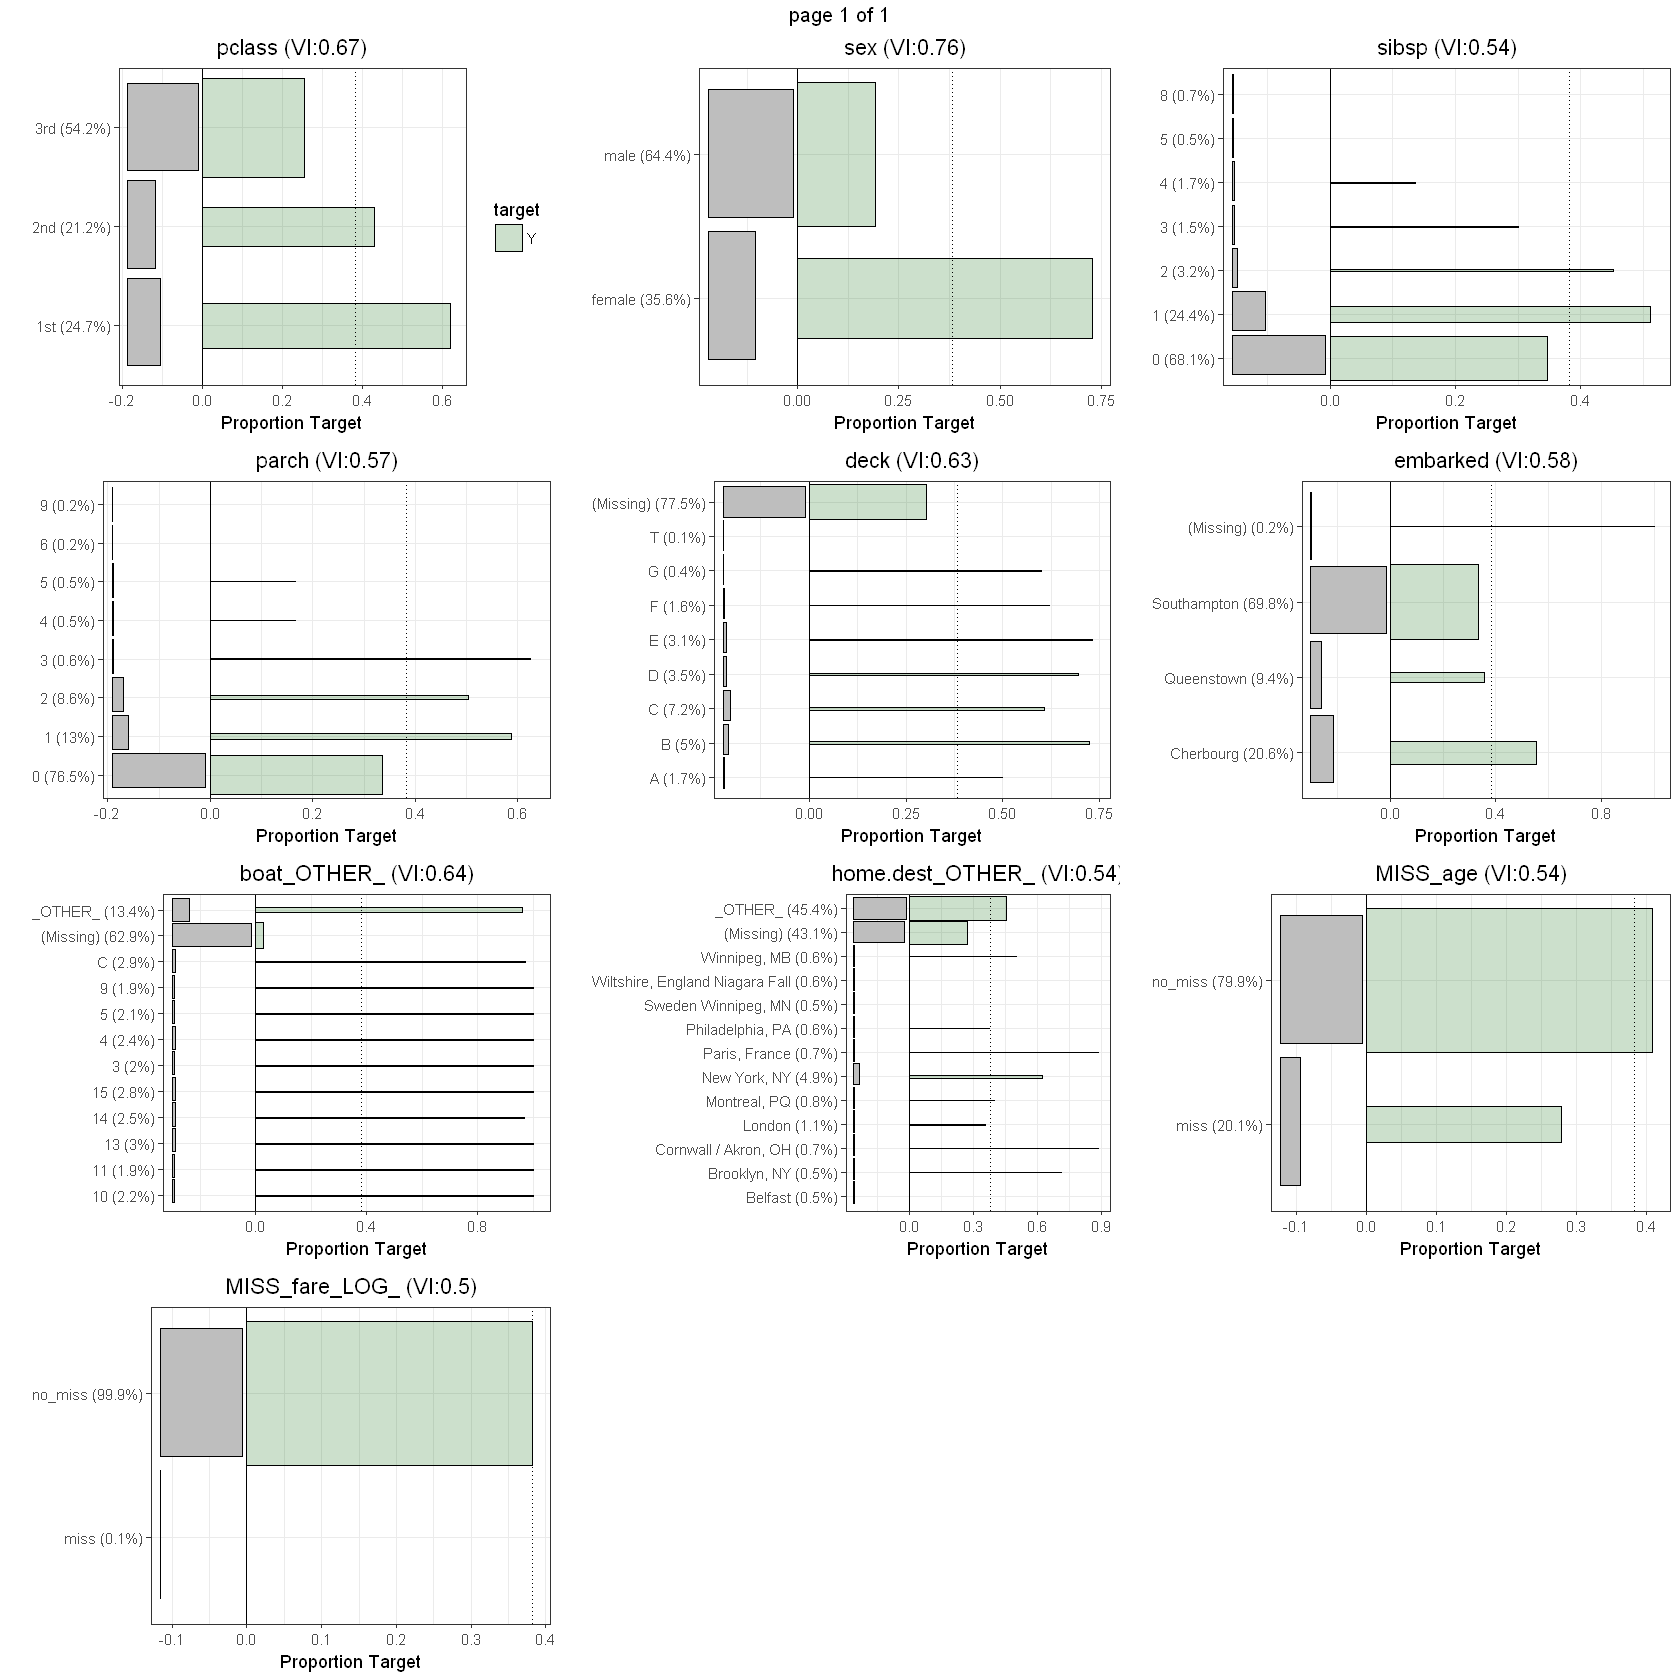

In [41]:
# Check
plots = suppressMessages(get_plot_distr_nomi(df, nomi, color = twocol, varimpinfo = varimp_nomi, inner_barplot = TRUE,
                                             min_width = 0, ylim = NULL))
#options(jupyter.plot_mimetypes = "image/svg+xml")
#options(jupyter.plot_mimetypes = "image/png")
options(repr.plot.width = 14, repr.plot.height = 14) #adapt this for different resolution
marrangeGrob(plots, ncol = 3, nrow = 4)

afgfag

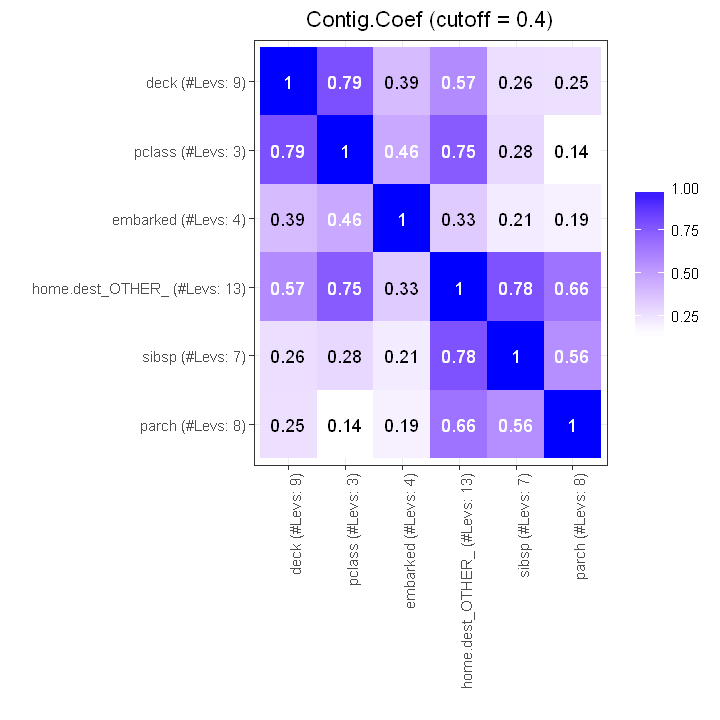

In [43]:
# Removing variables ----------------------------------------------------------------------------------------------

# Remove Self-features
nomi = setdiff(nomi, "boat_OTHER_")


# Remove highly/perfectly (>=99%) correlated (the ones with less levels!) 
plot = get_plot_corr(df, input_type = "nomi",  vars = setdiff(nomi, paste0("MISS_",miss)), cutoff = 0.4)
options(repr.plot.width = 6, repr.plot.height = 6) #adapt this for different resolution
plot

